In [ ]:
import cv2
from  ultralytics import YOLO
import time
import numpy as np
import mediapipe as mp
import csv
import psutil
import os
import gc


class EARCalculator:
    def get_eye_coordinates(selft,landmarks, eye_indices):
        if len(landmarks) < max(eye_indices):
            return None
        else:
            return np.array([(landmarks[idx].x,landmarks[idx].y) for idx in eye_indices])

    def get_EAR(self,eye):
        v1 = np.linalg.norm(eye[1]-eye[5])
        v2 = np.linalg.norm(eye[2]-eye[4])

        h = np.linalg.norm(eye[0]-eye[3])
        #EAR Calculation
        EAR = (v1+v2)/(2.0*h)
        return EAR
    
    def get_avg_ear(self,leftEAR,rightEAR) :
        return ((leftEAR+rightEAR)/2.0)
    
class BlinkDetector:
    def __init__(self,initial_blink_threshold=0.3,blink_time_threshold=0.3,close_time_threshold=3.0):
        self.blink_thresholds = []
        self.blinkThreshold =initial_blink_threshold
        self.EAR_cal = EARCalculator()
        #Left eye + Right eye mediapipe indices
        self.LEFT_EYE = [362,385,387,263,373,380]
        self.RIGHT_EYE = [33,160,158,133,153,144]
        self.currentBlinkCount = 0
        self.isBlinking = False
        self.blinkStartTime = 0
        self.blinkTimeThreshold = blink_time_threshold
        self.closeTimeThreshold = close_time_threshold
        self.currentEyeCloseCount = 0

    def get_current_blink_count(self) :
        return self.currentBlinkCount
    
    def get_current_eye_close_count(self) :
        return self.currentEyeCloseCount
    

    def update_blink_threshold(self,averageEAR,alpha=0.25):
        """
        Update the blink threshold using exponential moving average (EMA).
        alpha: Smoothing factor (0 < alpha <= 1)
        """
        self.blinkThreshold = (alpha * averageEAR) + ((1 - alpha) * self.blinkThreshold)

    def process(self,landmark,timeStamp):
        if not landmark:return
        left_eye = self.EAR_cal.get_eye_coordinates(landmark,self.LEFT_EYE)
        right_eye = self.EAR_cal.get_eye_coordinates(landmark,self.RIGHT_EYE)
        leftEAR = self.EAR_cal.get_EAR(left_eye)
        rightEAR = self.EAR_cal.get_EAR(right_eye)

        avgEAR = self.EAR_cal.get_avg_ear(leftEAR,rightEAR)
        #self.update_blink_threshold(averageEAR=avgEAR)

        if avgEAR<=self.blinkThreshold :
            if not self.isBlinking :
                self.blinkStartTime = timeStamp
                self.isBlinking = True
        else:
            if self.isBlinking :
                self.isBlinking = False
                blinkDuration = timeStamp - self.blinkStartTime
                if blinkDuration <= self.blinkTimeThreshold :
                    self.currentBlinkCount += 1
                    return "blink"
                elif blinkDuration >= self.closeTimeThreshold :
                    self.currentEyeCloseCount += 1
                    return "eye_close"
        return None

def apply_clahe(frame):
    """Apply CLAHE to enhance contrast in the image."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray)
    return cv2.cvtColor(enhanced_gray, cv2.COLOR_GRAY2BGR)

def run_inference(model,frame,conf=0.5):
    """
    Run YOLO inference on a single frame and return the class with the highest confidence.

    Args:
        model: A YOLO model instance.
        frame (np.ndarray): The frame/image from OpenCV.
        num_classes (int): Total number of classes in the model.
        conf (float): The confidence threshold for detections.

    Returns:
        int or None: The class index with the highest confidence, or None if no detection.
    """
    max_confidence = -1
    frame = apply_clahe(frame)
    results = model.predict(frame,conf=conf,verbose=False)
    cls_idx_return = None
    for result in results:
            if result.boxes is not None:
                for box in result.boxes:
                    cls_idx = int(box.cls[0])
                    confidence = float(box.conf[0])  # Get the confidence of this detection
                    # Update dominant_class if this detection has higher confidence
                    if confidence > max_confidence:
                        max_confidence = confidence
                        cls_idx_return = cls_idx

    return  cls_idx_return


#load models
#LeDro {0=active,1=drowsiness}
LeDro = YOLO('models/LeDro.pt').to('cuda')
#LeEmo  ['angry', 'disgust', 'fear', 'happy', 'neutral','sad', 'surprise']
LeEmo = YOLO('models/LeEmo.pt').to('cuda')
#LeET
# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True,min_detection_confidence=0.5,min_tracking_confidence=0.5)
blink_detector = BlinkDetector(initial_blink_threshold=0.3)
#LeET YOLO based {0=on screen,1=off screen}
LeET = YOLO('models/LeET.pt').to('cuda')


datasetFolder = './dataset'
resultFolder = './new_data'
print('Start Extracting')
for filename in os.listdir(datasetFolder):
    print(f'----Process {filename}...')
    print(f'Memory usage start:{psutil.virtual_memory().used/(1024**3):.2f} GB')
    video = cv2.VideoCapture(os.path.join(datasetFolder,filename))
    if not video.isOpened():
        print(f"Error: Cannot open {filename}")
        continue
    fps = video.get(cv2.CAP_PROP_FPS) or fps
    frames_per_minute = int(fps * 60)
    resultFile = os.path.join(resultFolder,os.path.splitext(filename)[0]+'.csv')
    subjID = filename.split('-')[0]+filename.split('-')[1]
    file_id = filename.split('-')[2]
    file_id = file_id.removesuffix('.mp4')
    with open(resultFile,mode='w',newline='') as file :
        # Keep track of the last detected class (None = no detection previously)
        ledro_prev_class = None
        ledro_class_counts = {0:0,1:0}
        leemo_prev_class = None
        leemo_class_counts = {'emo_change':0,
                                'emotion': {i: 0 for i in range(7)}}
        leet_prev_class = None
        leet_class_counts = {0:0,1:0}

        last_log_time = time.time()
        log_interval = 60

        writer = csv.writer(file)
        header = ['SubjID','FileID','Minute','active','drowsiness',
                'EmotionChange','Neutral','Happy','Surprise','Angry','Sad','Fear','Disgust',
                'Blinked','Closed','OnScreen','OutScreen']
        writer.writerow(header)
        frame_count = 0
        current_minute = 0
        while True:
            ret, frame = video.read()
            if not ret:
                break

            ledro_result = run_inference(model=LeDro,frame=frame,conf=0.5)
            if ledro_result is not None and ledro_result != ledro_prev_class:
                ledro_class_counts[ledro_result] += 1
            ledro_prev_class = ledro_result

            leemo_result = run_inference(model=LeEmo,frame=frame,conf=0.3)  
            if leemo_result is not None and leemo_result != leemo_prev_class:
                leemo_class_counts['emotion'][leemo_result] += 1
                leemo_class_counts['emo_change'] += 1
            leemo_prev_class = leemo_result

            leet_result = run_inference(model=LeET,frame=frame,conf=0.5) 
            if leet_result is not None and leet_result != leet_prev_class:
                leet_class_counts[leet_result] += 1
            leet_prev_class = leet_result


            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_results = face_mesh.process(frame_rgb)
            if face_results.multi_face_landmarks:
                for face_landmarks in face_results.multi_face_landmarks:
                    blink_detector.process(face_landmarks.landmark, time.time()) 

            # Check if a minute has passed
            if frame_count >= frames_per_minute:
                writer.writerow([subjID,file_id,current_minute+1,
                                ledro_class_counts[0],
                                ledro_class_counts[1],
                                leemo_class_counts['emo_change'],
                                leemo_class_counts['emotion'][4],
                                leemo_class_counts['emotion'][3],
                                leemo_class_counts['emotion'][6],
                                leemo_class_counts['emotion'][0],
                                leemo_class_counts['emotion'][5],
                                leemo_class_counts['emotion'][2],
                                leemo_class_counts['emotion'][1],
                                blink_detector.get_current_blink_count(),
                                blink_detector.get_current_eye_close_count(),
                                leet_class_counts[0],
                                leet_class_counts[1]
                                ])
                print(f"Minute {current_minute+1} logged.")
                print("LeDro Log :", ledro_class_counts)
                print("LeEmo Log :", leemo_class_counts)
                print(f"Blink Count: {blink_detector.get_current_blink_count()}, Eye Close Count: {blink_detector.get_current_eye_close_count()}")
                print("LeET Log :", leet_class_counts)

                # Reset the counts after logging
                ledro_class_counts = {0: 0, 1: 0}
                leemo_class_counts = {'emo_change':0,
                                'emotion':{i:0 for i in range(7)}}
                leet_class_counts = {0:0,1:0}
                blink_detector.currentBlinkCount = 0
                blink_detector.currentEyeCloseCount = 0
                    
                ledro_prev_class = None
                leemo_prev_class = None
                leet_prev_class = None

                current_minute += 1
                frame_count = 0
            frame_count += 1
    gc.collect()
    print(f'--- Process {filename} DONE!!')
    print(f'Memory usage after: {psutil.virtual_memory().used/(1024**3):.2f} GB')
print('Extracting done')


Merge ConLevel From Old data

In [ ]:
import pandas as pd
import os

# Folder paths for new and old data
new_data_folder = './new_data'
old_data_folder = './old_data'
result_folder = './extracted_result'

# Ensure the result folder exists
os.makedirs(result_folder, exist_ok=True)

# List all new data files
new_files = [f for f in os.listdir(new_data_folder) if f.endswith('.csv')]

# Process each new data file
for new_file in new_files:
    # Read new and old data
    new_data_path = os.path.join(new_data_folder, new_file)
    old_data_path = os.path.join(old_data_folder, new_file)  # Assuming same file names
    
    if not os.path.exists(old_data_path):
        print(f"Old data file not found for {new_file}. Skipping.")
        continue
    
    new_df = pd.read_csv(new_data_path)
    old_df = pd.read_csv(old_data_path)
    
    # Merge new and old data on SubjID, FileID, and Minute
    merged_df = pd.merge(new_df, old_df[['SubjID', 'FileID', 'Minute', 'conLevel']],
                         on=['SubjID', 'FileID', 'Minute'], how='left')
    
    # Save the merged result
    result_path = os.path.join(result_folder, new_file)
    merged_df.to_csv(result_path, index=False)
    
    print(f"Merged file saved: {result_path}")


Mege All Files

In [ ]:
import pandas as pd
import os

# Path to the folder containing merged CSV files
merged_data_folder = './extracted_result'
output_file = './data.csv'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(merged_data_folder) if f.endswith('.csv')]

# Initialize an empty list to store dataframes
dataframes = []

# Read each CSV file and append it to the list
for file in csv_files:
    file_path = os.path.join(merged_data_folder, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Save the combined dataframe to a single CSV file
combined_df.to_csv(output_file, index=False)

print(f"All files merged successfully into: {output_file}")


Data Cleansing

In [2]:
import pandas as pd

# Load the uploaded dataset
file_path = 'data.csv'
data = pd.read_csv(file_path)

# Display initial data info and first few rows for inspection
data_info = data.info()
data_head = data.head()

data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SubjID         1005 non-null   object 
 1   FileID         1005 non-null   int64  
 2   Minute         1005 non-null   int64  
 3   active         1005 non-null   int64  
 4   drowsiness     1005 non-null   int64  
 5   EmotionChange  1005 non-null   int64  
 6   Neutral        1005 non-null   int64  
 7   Happy          1005 non-null   int64  
 8   Surprise       1005 non-null   int64  
 9   Angry          1005 non-null   int64  
 10  Sad            1005 non-null   int64  
 11  Fear           1005 non-null   int64  
 12  Disgust        1005 non-null   int64  
 13  Blinked        1005 non-null   int64  
 14  Closed         1005 non-null   int64  
 15  OnScreen       1005 non-null   int64  
 16  OutScreen      1005 non-null   float64
 17  conLevel       982 non-null    float64
dtypes: float

(None,
   SubjID  FileID  Minute  active  drowsiness  EmotionChange  Neutral  Happy  \
 0   S001       1       1      17          16             47        5      0   
 1   S001       1       2       1          16             40        7      0   
 2   S001       1       3       0           1             52        4      0   
 3   S001       1       4       0           2            100        1      0   
 4   S001       2       1       3           8             88       14      0   
 
    Surprise  Angry  Sad  Fear  Disgust  Blinked  Closed  OnScreen  OutScreen  \
 0         0     18   24     0        0       10       0         3        0.0   
 1         0     11   22     0        0        7       0         0        0.0   
 2         0     22   26     0        0        7       0         0        0.0   
 3         0     48   51     0        0        9       0         0        0.0   
 4         0     23   51     0        0       24       0         0        0.0   
 
    conLevel  
 0      

Check outlier & inconsistent value

In [7]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('data.csv')

# Step 1: Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Handle missing values (if any)
# Example: Fill missing values with median (you can choose other methods as needed)
df = df.dropna(subset=['conLevel'])

# Step 2: Check for duplicate records
print("\nNumber of duplicate records:", df.duplicated().sum())

# Step 2: Check for and remove duplicate records
duplicates = df.duplicated()
df = df.drop_duplicates()

# Step 3: Check for outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1                   # Interquartile range
    lower_bound = Q1 - 1.5 * IQR    # Lower bound
    upper_bound = Q3 + 1.5 * IQR    # Upper bound
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

print("\nOutliers detected (using IQR method):")
for col in df.select_dtypes(include=[np.number]).columns:  # Apply only to numeric columns
    outliers = detect_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers")

# Optionally: Remove outliers (uncomment the next line if you want to remove them)
# df = df[~df.index.isin(outliers.index)]

# Step 4: Check for inconsistent values in categorical features
# Assuming 'ConLevel' is a categorical feature with known valid values [0, 1, 2, 3]
valid_conlevels = [0, 1, 2, 3]
invalid_conlevels = df[~df['conLevel'].isin(valid_conlevels)]
print(f"\nNumber of inconsistent 'conLevel' values: {len(invalid_conlevels)}")

# Optionally: Remove inconsistent values (if necessary)
# df = df[df['ConLevel'].isin(valid_conlevels)]

# Save the cleaned data to a new file
df.to_csv('cleaned_data.csv', index=False)
print("\nData cleaning complete. Cleaned data saved as 'cleaned_data.csv'.")


Missing values per column:
SubjID            0
FileID            0
Minute            0
active            0
drowsiness        0
EmotionChange     0
Neutral           0
Happy             0
Surprise          0
Angry             0
Sad               0
Fear              0
Disgust           0
Blinked           0
Closed            0
OnScreen          0
OutScreen         0
conLevel         23
dtype: int64

Number of duplicate records: 6

Outliers detected (using IQR method):
FileID: 0 outliers
Minute: 21 outliers
active: 20 outliers
drowsiness: 56 outliers
EmotionChange: 34 outliers
Neutral: 183 outliers
Happy: 154 outliers
Surprise: 28 outliers
Angry: 27 outliers
Sad: 20 outliers
Fear: 76 outliers
Disgust: 34 outliers
Blinked: 64 outliers
Closed: 105 outliers
OnScreen: 35 outliers
OutScreen: 103 outliers
conLevel: 0 outliers

Number of inconsistent 'conLevel' values: 0

Data cleaning complete. Cleaned data saved as 'cleaned_data.csv'.


Handle outlier

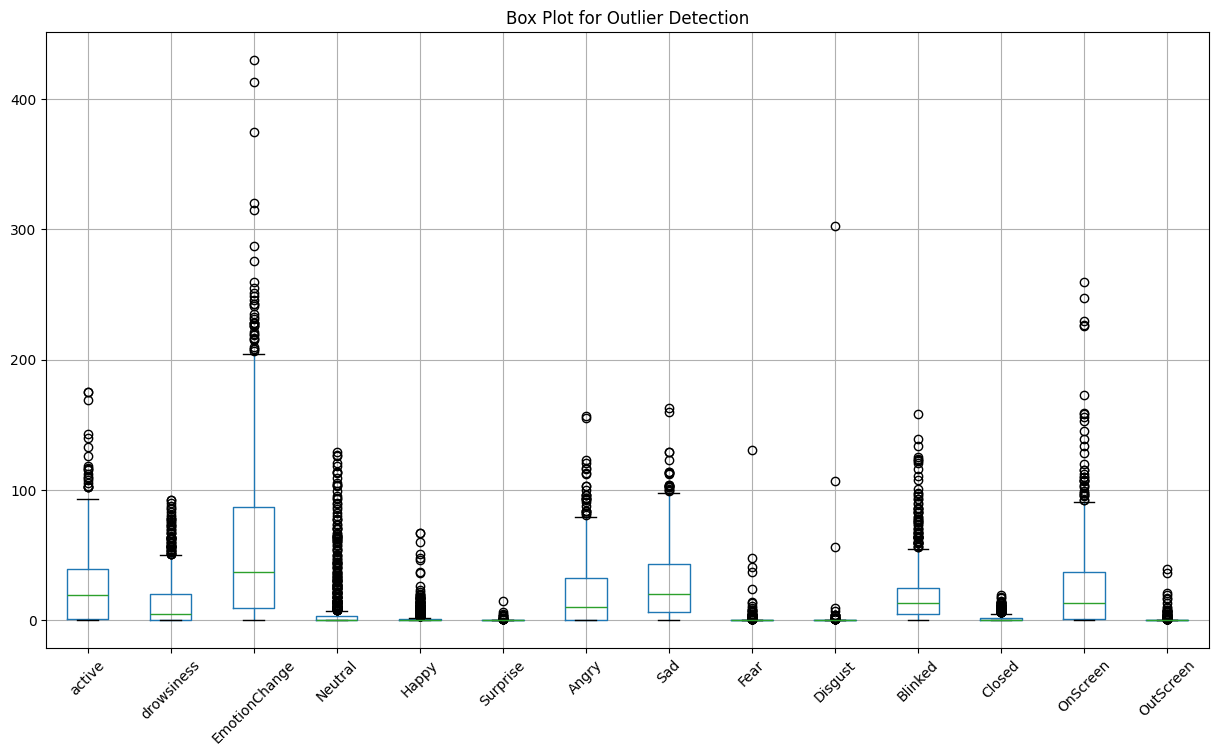

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('cleaned_data.csv')

# Plot box plots for each feature to visualize outliers
features = df.columns.drop(['SubjID', 'FileID', 'Minute', 'conLevel'])
df[features].boxplot(figsize=(15, 8), rot=45)
plt.title('Box Plot for Outlier Detection')
plt.show()

Robust Scailing

  SubjID  FileID  Minute  active  drowsiness  EmotionChange  Neutral  Happy  \
0   S001       1       1      17          16             47        5      0   
1   S001       1       2       1          16             40        7      0   
2   S001       1       3       0           1             52        4      0   
3   S001       1       4       0           2            100        1      0   
4   S001       2       1       3           8             88       14      0   

   Surprise  Angry  Sad  Fear  Disgust  Blinked  Closed  OnScreen  OutScreen  \
0         0     18   24     0        0       10       0         3        0.0   
1         0     11   22     0        0        7       0         0        0.0   
2         0     22   26     0        0        7       0         0        0.0   
3         0     48   51     0        0        9       0         0        0.0   
4         0     23   51     0        0       24       0         0        0.0   

   conLevel  
0       2.0  
1       2.0  
2 

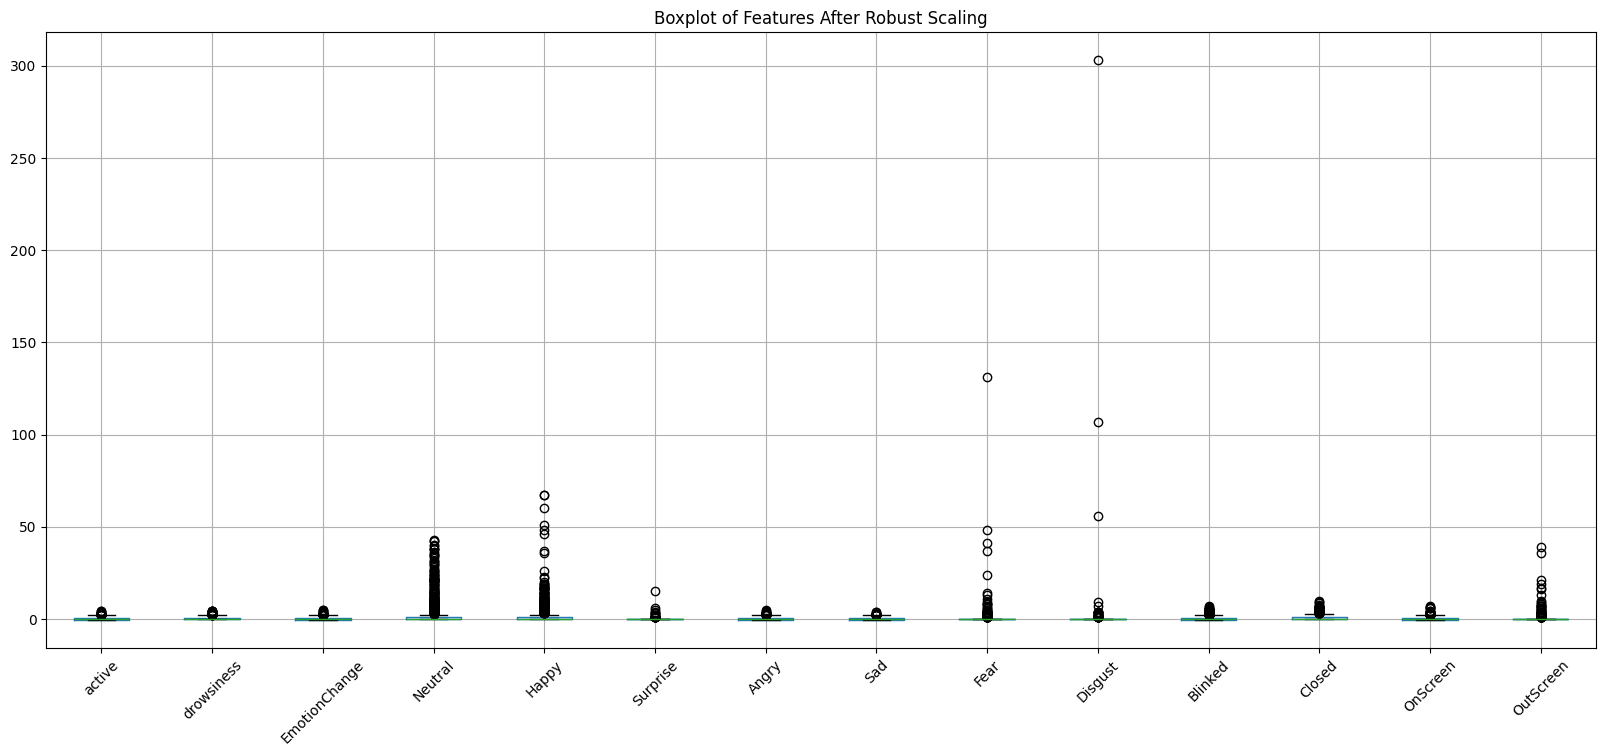

  SubjID  FileID  Minute    active  drowsiness  EmotionChange   Neutral  \
0   S001       1       1 -0.052632        0.55       0.128205  1.666667   
1   S001       1       2 -0.473684        0.55       0.038462  2.333333   
2   S001       1       3 -0.500000       -0.20       0.192308  1.333333   
3   S001       1       4 -0.500000       -0.15       0.807692  0.333333   
4   S001       2       1 -0.421053        0.15       0.653846  4.666667   

   Happy  Surprise    Angry       Sad  Fear  Disgust  Blinked  Closed  \
0    0.0       0.0  0.25000  0.108108   0.0      0.0    -0.15     0.0   
1    0.0       0.0  0.03125  0.054054   0.0      0.0    -0.30     0.0   
2    0.0       0.0  0.37500  0.162162   0.0      0.0    -0.30     0.0   
3    0.0       0.0  1.18750  0.837838   0.0      0.0    -0.20     0.0   
4    0.0       0.0  0.40625  0.837838   0.0      0.0     0.55     0.0   

   OnScreen  OutScreen  conLevel  
0 -0.277778        0.0       2.0  
1 -0.361111        0.0       2.0  
2 -0.

In [13]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sn

# Load the dataset
df = pd.read_csv('cleaned_data.csv')

# Display the first few rows to verify
print(df.head())
# Select features to scale (exclude SubjID, FileID, Minute, and conLevel)
features_to_scale = df.columns.drop(['SubjID', 'FileID', 'Minute', 'conLevel'])

# Initialize RobustScaler
scaler = RobustScaler()

# Apply scaling
df_scaled = df.copy()  # Create a copy of the original dataframe
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])
plt.figure(figsize=(20, 8))
df_scaled[features].boxplot()
plt.title("Boxplot of Features After Robust Scaling")
plt.xticks(rotation=45)
plt.show()
# Display the scaled data
print(df_scaled.head())
df_scaled.to_csv('scaled_data.csv', index=False)

Feature Selection by correlation analysis (Pearson)

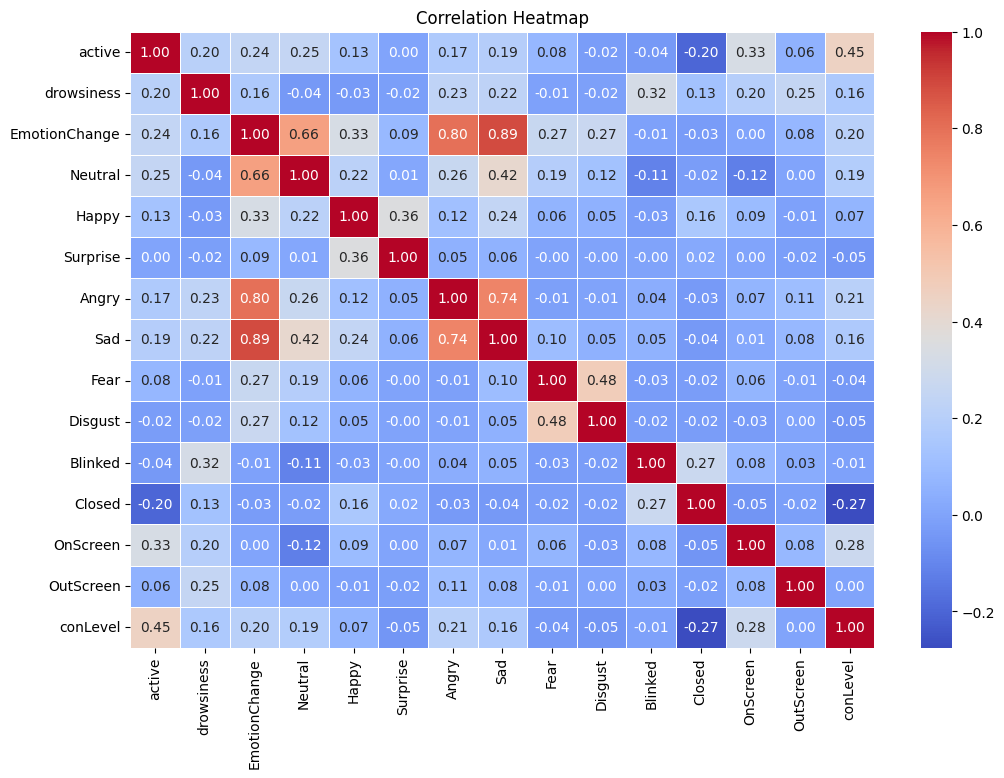

Selected features based on correlation (>= 0.3):
['active']


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('cleaned_data.csv')
# Drop identifier columns before correlation analysis
df = df.drop(columns=['SubjID', 'FileID', 'Minute'])

# Compute the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Find correlation of each feature with 'conLevel'
target_correlation = correlation_matrix['conLevel'].drop(['conLevel'])
selected_features = target_correlation[abs(target_correlation) >= 0.3].index.tolist()

print("Selected features based on correlation (>= 0.3):")
print(selected_features)
